In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [15]:
def get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, n_modes_trunc, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    
    #take a regular subset of the modes
    if n_modes_trunc > 0 and n_modes_trunc < len(k_tab):
        print("Truncating the momentum space to ", n_modes_trunc, " modes")
        k_tab = k_tab[::int(len(k_tab)/n_modes_trunc)]  

    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    
        if use_WW_approx:
        ##off diagonal elements
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_tab[i] / L)*1j

        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    H_matrix[n_modes, n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Initializing the state ...")
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom
    N_k_t = np.zeros((n_modes, n_step))
    N_A_t = np.zeros(n_step)
    overlap_free_evol = np.zeros(n_step)


    print("Computing occupation numbers in momentum space...")
    for t in tqdm(range(n_step)):
        current_state = state_list[t]

        for i in range(n_modes):
            momentum_state = qt.basis(dim_subspace, i)
            N_k_t[i, t] = np.abs(momentum_state.dag() * current_state)**2

        atomic_state = qt.basis(dim_subspace, n_modes)
        N_A_t[t] += np.abs(atomic_state.dag() * current_state)**2
        
        overlap_free_evol[t] = np.abs(state_list_free[t].dag() * current_state)**2

    return times, k_tab, N_k_t, N_A_t, overlap_free_evol

<h1> First test </h1>

Check the parameters first

In [16]:
L = 250*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
omega_0 = omega_A - 0.1

#numerical implementation of momentum space
omega_max = 10
n_modes_trunc = 100000

print("Coupling g(k,j): ", g_0*np.sqrt(omega_A / L))
print("sigma_momentum: ", sigma_momentum)
print("Decay rate gamma: ", gamma)


Coupling g(k,j):  0.006180387232371035
sigma_momentum:  0.020371832715762605
Decay rate gamma:  0.06000000000000001


Now, run the function

In [17]:
times, k_tab, N_k_t, N_A_t, overlap_free_evol = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, n_modes_trunc, g_0, sigma, x_0, print_nb_modes = True)

Number of modes:  2501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   2.44s. Est. time left: 00:00:00:21
20.0%. Run time:   4.68s. Est. time left: 00:00:00:18
30.0%. Run time:   6.97s. Est. time left: 00:00:00:16
40.0%. Run time:   9.30s. Est. time left: 00:00:00:13
50.0%. Run time:  11.55s. Est. time left: 00:00:00:11
60.0%. Run time:  14.31s. Est. time left: 00:00:00:09
70.0%. Run time:  16.68s. Est. time left: 00:00:00:07
80.0%. Run time:  19.20s. Est. time left: 00:00:00:04
90.0%. Run time:  21.74s. Est. time left: 00:00:00:02
100.0%. Run time:  24.00s. Est. time left: 00:00:00:00
Total run time:  24.00s
Computing occupation numbers in momentum space...


  0%|          | 0/3926 [00:00<?, ?it/s]

<h1> R and T coefficients </h1>

Try to define reflection and transmission cofficients ? Let me define:

$N_k = a_k^{\dagger} a_k$ and $N_x = a_x^{\dagger} a_x$ where :

$$a_x = \frac{1}{\sqrt{N}} \sum_k e^{ikx} a_k$$

I can define : 

$$P_-(t) = \sum_{k < 0} N_k \,\, , \,\, P_+(t) = \sum_{k > 0} N_k $$

It is also interesting to check that the atomic number remains close to zero :

$$ N_A = \sum_j \left(\frac{1+\sigma_j^z}{2}\right)$$

The transmission coefficient is $T = P_+(\infty)$ and the reflection is $R = P_-(\infty)$

Results from summation per modes
T =  0.9047618521040918
R =  0.09523814449768328
Final occupation of the atom =  3.3982233524181472e-09
---------------------------------------------------------
Results from overlap
T =  0.9026060114229073
R =  0.09739398517886934
Final occupation of the atom =  3.3982233524181472e-09


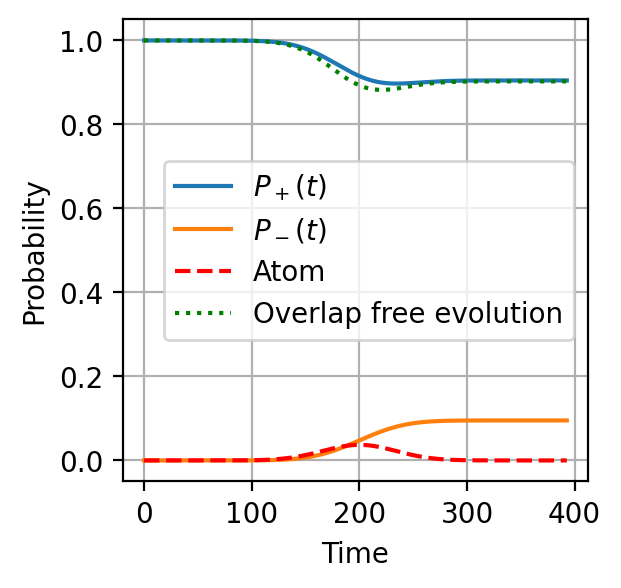

In [18]:
n_modes = N_k_t.shape[0]

nb_pts = len(times)
P_p = np.zeros(nb_pts)
P_m = np.zeros(nb_pts)

for t in range(nb_pts):
    for i in range(n_modes): 
        if k_tab[i] > 0:
            P_p[t] += N_k_t[i,t]
        else:
            P_m[t] += N_k_t[i,t]


print("Results from summation per modes")
print("T = ", P_p[-1])
print("R = ", P_m[-1])
print("Final occupation of the atom = ", N_A_t[-1])
print("---------------------------------------------------------")
print("Results from overlap")
print("T = ", overlap_free_evol[-1])
print("R = ", 1- overlap_free_evol[-1]- N_A_t[-1])
print("Final occupation of the atom = ", N_A_t[-1]) 


fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, P_p, label=r'$P_+(t)$')
ax.plot(times, P_m, label=r'$P_-(t)$')
#ax.plot(times, P_p+P_m, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(times, N_A_t, label='Atom', linestyle='--', color='red')   
ax.plot(times, overlap_free_evol, label='Overlap free evolution', linestyle=':', color='green')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()